In [6]:
import torch 
import copy
import json 
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose   
from types import SimpleNamespace


OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 
from utils_pdhg import *


ValueError: resolver 'div' is already registered

In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw_warm_start_only",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pd_adamw_warm_start_only and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.01, pdhg_iters=0, warm_start=True
    momentum=False, diag_scaling=True, accel=False, pd_type='pdhg', halpern_start=5, reflected_pdhg=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 7.421211242675781
In rank: 0, time taken for epoch 1 :

In [7]:
with initialize(config_path="../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start_only/bs-4-lr-0.001-wd-0/attn_pd_adamw_warm_start_only-lr-0.001-constant-linear-f8beffee847527bd4aca146cca6e3c41.json


iteration=0
  layer   W_q_norm   W_k_norm  G_q_norm  G_k_norm    Y_norm
0     0  81.437004  79.457664  0.013209  0.013600  0.037183
1     1  79.834427  76.288605  0.003659  0.003802  0.010935
2     2  70.105637  73.169281  0.001973  0.002151  0.005642
3     3  70.321617  81.717636  0.001705  0.001678  0.004739


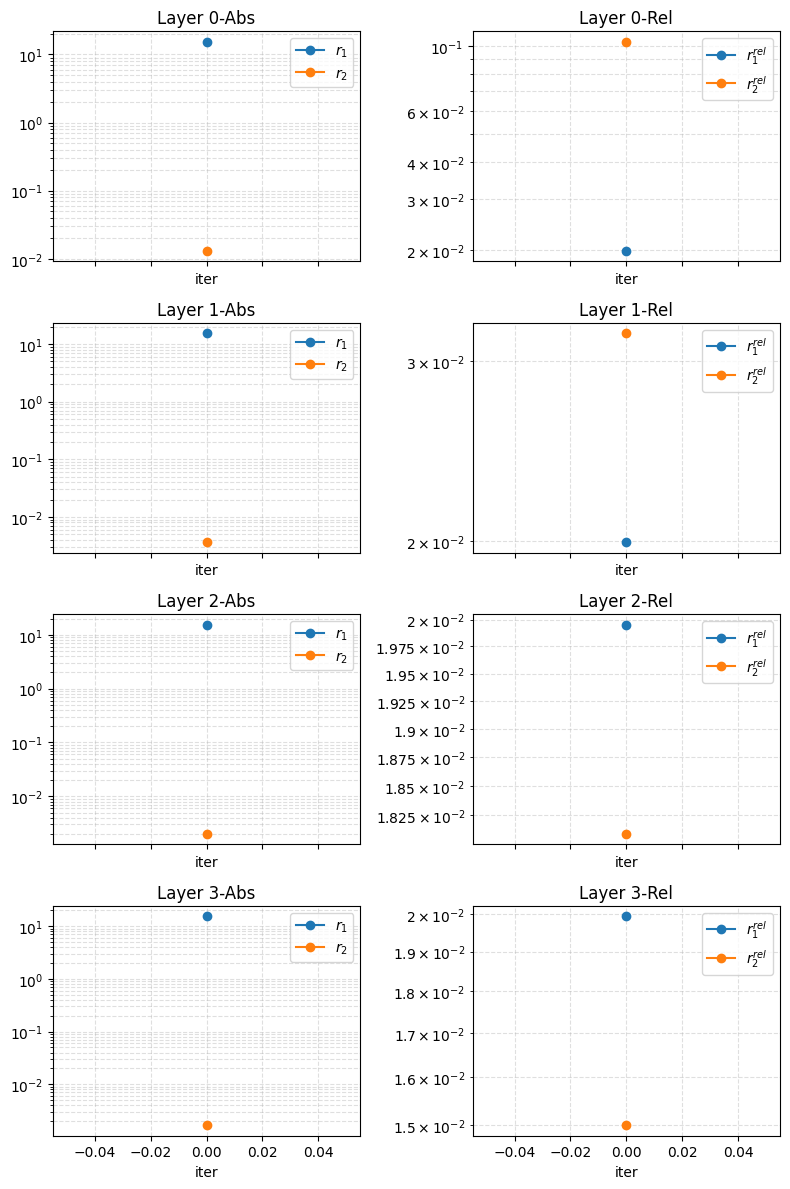

In [8]:
it = 0
print(f"iteration={it}")
import pandas as pd
it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)

plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=50
  layer      W_q_norm      W_k_norm      G_q_norm  G_k_norm    Y_norm
0     0    181.713013     71.465805  1.787412e-01  0.270290  0.209342
1     1    705.923096   9935.034180  1.610449e-05  0.004309  0.001003
2     2  11857.685547  15710.226562  2.901983e-07  0.001776  0.000380
3     3  10707.233398  16313.491211  1.009017e-07  0.000269  0.000092


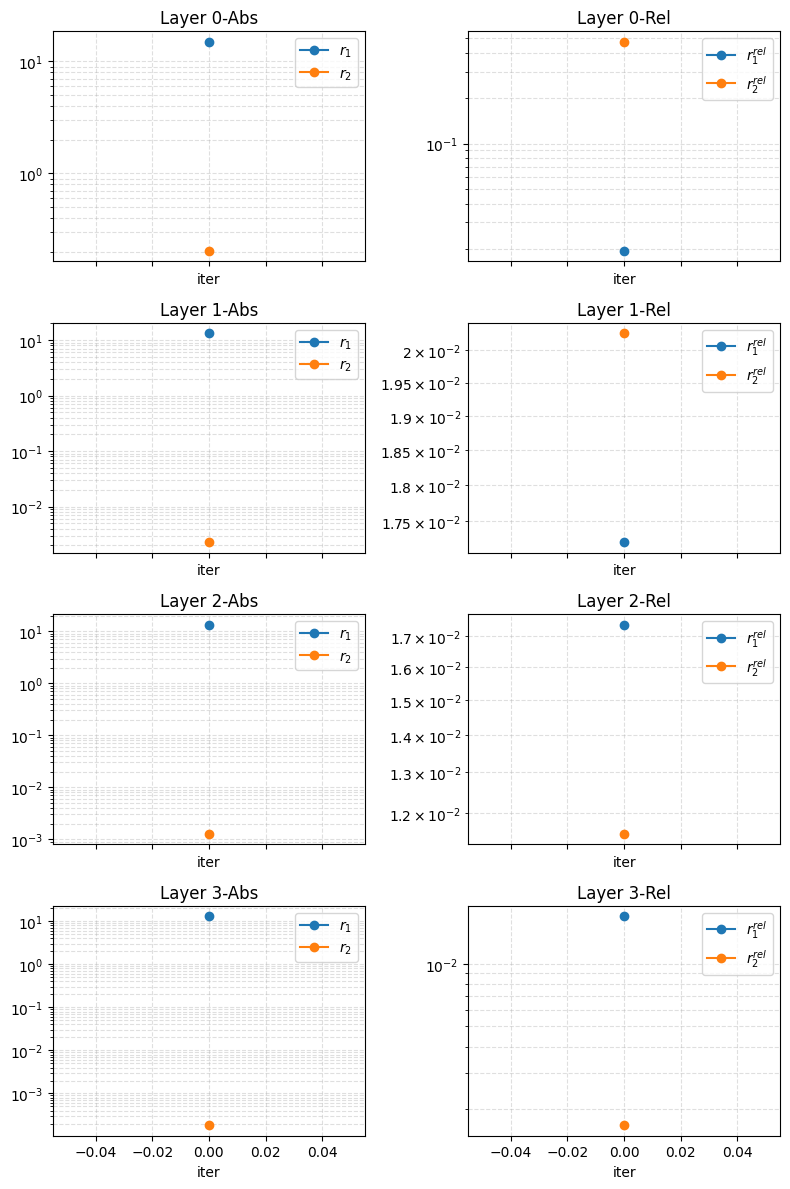

In [9]:
it = 50
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1
  layer     W_q_norm     W_k_norm      G_q_norm  G_k_norm    Y_norm
0     0  1136.919067   717.137573  1.130616e-02  0.046780  0.023012
1     1  7183.645996  3892.769043  6.576130e-06  0.000158  0.000104
2     2  4432.490723  3963.223633  1.916719e-07  0.000113  0.000015
3     3  3172.530518  1286.357666  7.073142e-08  0.000015  0.000005


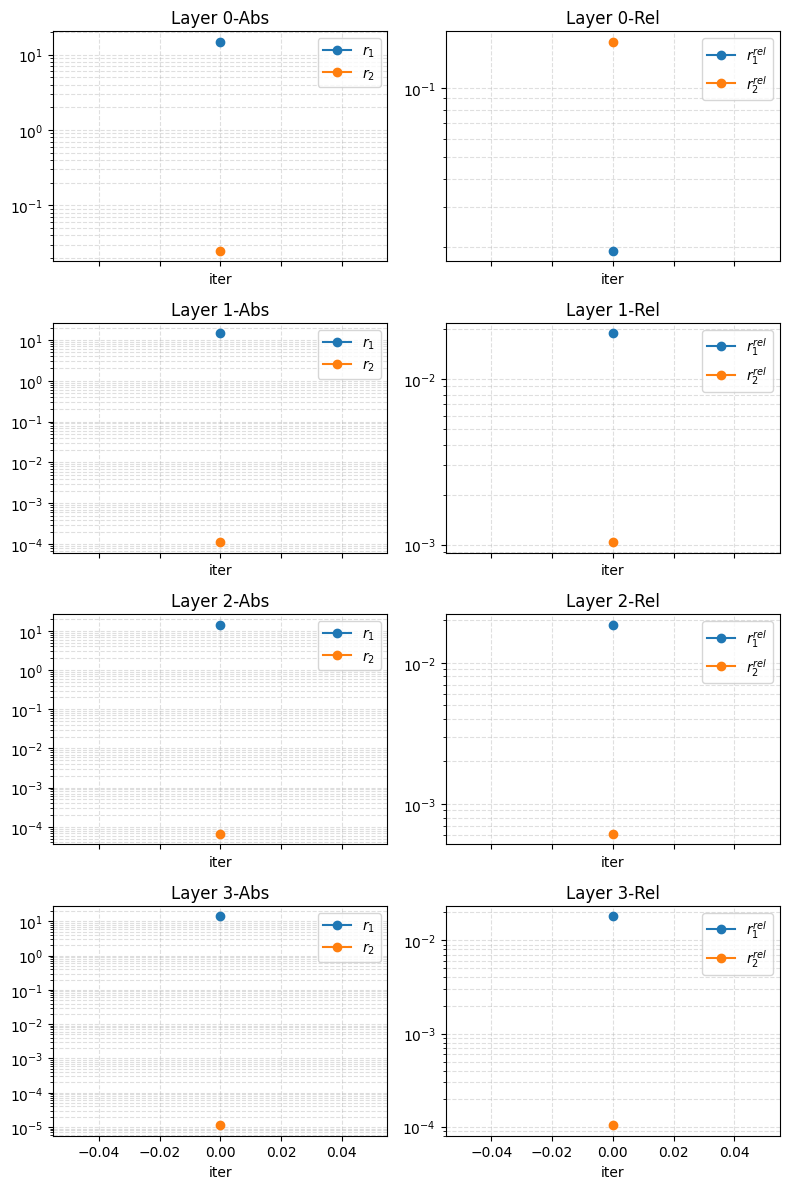

In [10]:
it = -1
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)